# Titanic Data Exploration and Classification
Hello, again. In this notebook, we'll go through some of the basic analysis and visualization techniques on the titanic dataset. We'll also try to classify the survivors using some basic machine learning models. The titanic dataset is very popular among beginners and often used for explaination purposes. Let's get right in to it.

## Data Exploration

### Loading and looking at the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv", index_col="PassengerId")
test_df = pd.read_csv("test.csv", index_col="PassengerId")
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We pretty much know the types of data columns, but let me recall them

- Numerical continous data (Data that consists of numbers taking any value like age or temprature)
    - Age
    - Fare
- Numerical descrete data (Data that indicates a quantity but takes only descrete values)
    - SibSp
- Categorical data (Data that takes descrete values indicating categories like sex or race)
    - Sex (Nominal)
    - Pclass (Ordinal)
    - Parch (Nominal)
    - Cabin (Nominal)
    - Embarked (Nominal)
    
Our label that we want to predict is the Survived column which takes values of 0 (died) or 1 (survived).  
Let's explore the data a bit more by calling [DataFrame.info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


So Age, Cabin and Embarked columns have some null values ... let's try to fix that

In [4]:
## age is a continous numerical variable, I am going to use the median to fill the null values
print(train_df["Age"].isnull().sum())
train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)
print(train_df["Age"].isnull().sum())

177
0


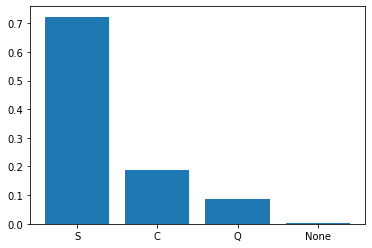

In [5]:
## now let's see the embarked column, it's a categorical column, let's see how many categories exist.
freq = train_df["Embarked"].fillna("None").value_counts(normalize=True)
plt.bar(freq.index, freq.values)
plt.show()

In [6]:
## now let's use the most frequent value to replace unkown values
train_df["Embarked"].fillna("S", inplace=True)

In [7]:
## now let's look at the values of the cabin series
train_df["Cabin"].nunique()

147

More that half of the values are unique, remember that there are only 204 known values in this column.  
Let's just drop it as it won't be so useful as is.  
There might be some sort of preprocessing that can make it work, however let's just drop it


In [8]:
## ticket column
train_df["Ticket"].nunique()

681

Tickets are also highly unique, so they might just confuse the model, so we'll drop that to.  
Now let's prepare our dataframe.

In [9]:
def preprocess(df, embarked_mapping=None):
    # drop un-needed columns
    df = df.drop(columns=["Name", "Ticket", "Cabin"])
    
    # emputing null values
    df["Embarked"] = df["Embarked"].fillna("S")
    df["Age"] = df["Age"].fillna(df["Age"].median())
    
    # binary encoding
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    
    # Standardizing numerical variables
    df["Fare"] = (df["Fare"].values - df["Fare"].mean()) / df["Fare"].std()
    df["Age"] = (df["Age"].values - df["Age"].mean()) / df["Age"].std()
    
    if embarked_mapping is None:
        # calculating means for mean encoding
        # in pandas you can put a condition in the square brackets
        # to select rows depending on that condition
        embarked_mapping = {
            "S": df[df["Embarked"] == "S"]["Survived"].mean(),
            "C": df[df["Embarked"] == "C"]["Survived"].mean(),
            "Q": df[df["Embarked"] == "Q"]["Survived"].mean(),
        }
    
    df["Embarked"] = df["Embarked"].map(embarked_mapping)
    
    ## the reason why we need the embarked_mappin dict is that in the test data we don't have the target
    ## so we cannot calculate the means for mean encoding, you always use the training encoding again
    return df, embarked_mapping

In [10]:
train_df_preprocessed, embarked_map = preprocess(train_df)
train_df_preprocessed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,-0.592148,1,0,-0.502163,0.339009
2,1,1,1,0.638430,1,0,0.786404,0.553571
3,1,3,1,-0.284503,0,0,-0.488580,0.339009
4,1,1,1,0.407697,1,0,0.420494,0.339009
5,0,3,0,0.407697,0,0,-0.486064,0.339009


## Classification
Now let's classify the passengers, but before we do we need to explain two important concepts. 
Concepts of the day:
- Cross validation (KFold)
- Grid Search

let's see each one of them alone

### Cross validation
Remeber back in the day when we used to split the data into train and test data? what if we split the data into $k$ parts, train the model on $k-1$ parts and validate against the last part, and repeat this for all splits of the data calculating our metric each time and averaging the results.. this is simply cross validation and it is very helpful to prevent overfitting or misleading evaluation metrics.  
Let's use the function [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)  
see also:
- [sklearn.model_selection.cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)
- [sklearn.model_selection.cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
X = train_df_preprocessed.drop(columns=["Survived"])
y = train_df_preprocessed["Survived"]

cross_val_score(model, X, y)

array([0.7877095 , 0.78651685, 0.78651685, 0.76404494, 0.82022472])

In [12]:
from sklearn.svm import SVC
model = SVC()

cross_val_score(model, X, y, cv=3)

array([0.8047138 , 0.82828283, 0.82154882])

now the svc model has a lot of parameters, how to choose between them? should we try all of them? this seems like a very booring process, what if we can automate it? well we can
### Grid search
Grid search is basically a very easy way to choose between parameters you can give to a model, we are not going to go into much details about the parameters you can give to the svc model, but you can always read the docs.

[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)  
[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [13]:
from sklearn.model_selection import GridSearchCV

## first we define the parameter grid,
## the grid search algorithm is simply going to create a model, fit it with each and every possible
## set of parameters, and then evaluate models using cross validation and keep the best model and
## best paramters
param_grid = [
    {
        "gamma": [1, 0.1,0.001],
        "C": [1,10],
        "kernel": ["rbf", "linear"]
    },
    {
        "gamma": [1,0.1,0.001],
        "C": [1,10],
        "kernel": ["poly"],
        "degree": [2, 3]
    }
]

# we pass the model, the grid and the splits of the cross validation
# the verbose parameter is just to output a lot of data from the process
# you'll see what I mean
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose=2)
grid_search.fit(X, y)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   37.7s finished


GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 10], 'gamma': [1, 0.1, 0.001],
                          'kernel': ['rbf', 'linear']},
                         {'C': [1, 10], 'degree': [2, 3],
                          'gamma': [1, 0.1, 0.001], 'kernel': ['poly']}],
             verbose=2)

In [14]:
## get the best parameters
grid_search.best_params_

{'C': 10, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}

In [15]:
## get the best score
grid_search.best_score_

0.8226711560044894

In [16]:
## now let's get the best model and do some predictions
model = grid_search.best_estimator_

test_df_preprocessed, embarked_map = preprocess(test_df, embarked_mapping=embarked_map)

test_df_preprocessed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 26.1 KB


In [17]:
## seems like the fare column has a null value, take good care since you might find nulls in columns
## in the test data that didn't have nulls in the training, it happened with me but I am covering it now XD

test_df_preprocessed["Fare"].fillna(test_df_preprocessed["Fare"].mean(), inplace=True)

preds = model.predict(test_df_preprocessed)

In [18]:
## now let's create a submission
test_df["Survived"] = preds
test_df = test_df[["Survived"]]

test_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0


In [19]:
test_df.to_csv("submission.csv")

### Random search
Now you try, search for random search on google and read the docs on it and see what you can do with it and when to use it. good luck

# The End